## Summary

This notebook contains analysis and plotting code using to generate figure 2 in Ryan et al. (2023). For further inquiries please contact Earle Wilson (earlew@stanford.edu). See accompanying readme doc for guidance on setting up Python environment.

## Data links

Data used in this analysis are stored in the `data/` directory. Links to the original data sources are provided below. Alternate data sources are also provided but these data may be in different formats.

sea ice (NOAA/NSIDC CDR v4): 
- retrieved from https://nsidc.org/data/g02202 
- alternate source: https://polarwatch.noaa.gov/erddap/files/nsidcG02202v4shmday/

SST (NOAA OI v2): 
- retrieved from https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html

Chl (NOAA VIIRS via polarwatch): 
- retrieved using: https://polarwatch.noaa.gov/catalog/chl-viirs-noaa-sq/preview/?dataset=monthly&var=chlor_a&time_min=2022-02-01T12:00:00Z&time_max=2022-02-01T12:00:00Z&proj=epsg3031&colorBar=KT_algae,,Log,0.001,10,
- alternate source (daily): https://polarwatch.noaa.gov/erddap/files/nesdisVHNSQchlaDaily/


SOCCOM float 5906226:
- retrieved from https://www.mbari.org/science/upper-ocean-systems/chemical-sensor-group/soccom-float-visualization/
Alternate source: https://fleetmonitoring.euro-argo.eu/float/5906226

Spatial ranges:
+ SST and Chl: 100W-0W, 75S-40S (for chl data, a stride of 5 was used for lat/lon)
+ sea ice: entire SO (no option to subselect pre-download)
+ SOCCOM float 5906226 (all available data)

Time ranges:
+ Chl: Jan 2012-Feb 2022, monthly
+ SST: Jan 1982-Feb 2022, monthly
+ SIE: 1978-May 2022, monthly 
+ SOCCOM float 5906226 (all available data)

## Import modules and set high-level controls

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt

import helper_functions as hf
from polar_convert import polar_xy_to_lonlat

#from matplotlib.ticker import FormatStrFormatter

from datetime import datetime, timedelta 
import calendar as cal
import pandas as pd

import seawater as sw

#import cmasher as cmr

In [28]:
plot_dir = 'plots/'
os.makedirs(plot_dir, exist_ok=True)

## Read-in data

In [4]:
# load data
data_dir = 'data/' # local directory (contains only the files needed for this notebook)

# SST
sst_fpath = os.path.join(data_dir, 'sst/noaa_sst_1982-2022_02_100W-0W_75S_40S.nc')
sst_ds = xr.open_dataset(sst_fpath)

# CDR v4 (sea ice conc.)
cdr_fpath = os.path.join(data_dir, 'sea_ice/merged_cdr_mon_seaice_conc_v4_ends_2022-05-01.nc')

cdr_ds = xr.open_dataset(cdr_fpath)
sic_v4 = cdr_ds['cdr_seaice_conc_monthly']
sic_dtimes = pd.to_datetime(sic_v4.time.values)

# soccom float
float_num = '5906226' # other options: '5906227',  '5905991'
fpath = os.path.join(data_dir, 'soccom_floats/%s_Sprof.nc'%float_num)
soccom_ds = xr.open_dataset(fpath)
soccom_ds['dtimes'] = pd.to_datetime(soccom_ds['JULD'].values)

In [7]:
# load Chl
chl_data_dir = 'data/chla/'
chl_fnames = os.listdir(chl_data_dir)

# combine yearly data files
ds_list = []
for fname in chl_fnames:
    if fname.endswith('stride5.nc'):
        chl_ds_ii = xr.open_dataset(os.path.join(chl_data_dir, fname))
        ds_list.append(chl_ds_ii.mean(dim='altitude'))

chl_ds_xx = xr.concat(ds_list, dim='time').sortby('time')
chl_ds = chl_ds_xx.rename(latitude='lat', longitude='lon')
chl_dtimes = pd.to_datetime(chl_ds.time.values)

In [8]:
# examine SST dataset
sst_ds

<xarray.Dataset>
Dimensions:    (lat: 35, lon: 100, time: 482, nbnds: 2)
Coordinates:
  * lat        (lat) float32 -40.5 -41.5 -42.5 -43.5 ... -71.5 -72.5 -73.5 -74.5
  * lon        (lon) float32 260.5 261.5 262.5 263.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2022-02-01
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) datetime64[ns] ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Mar 30 16:27:11 2022: ncrcat -O -n 1,3,1 /httpd/psd/t...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/
    NCO:            netCDF Operators version 4.8.1 (Homepage = http://nco.sf....

In [9]:
# exmine chl data
print(chl_ds)

<xarray.Dataset>
Dimensions:  (time: 122, lat: 187, lon: 534)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-02T12:00:00 ... 2022-02-01T12:00:00
  * lat      (lat) float64 -39.99 -40.18 -40.37 -40.56 ... -74.49 -74.68 -74.87
  * lon      (lon) float64 -99.99 -99.81 -99.62 ... -0.4313 -0.2438 -0.05625
Data variables:
    chlor_a  (time, lat, lon) float32 0.1181 0.1186 0.1251 ... nan nan nan


## Regrid sea ice data

For more info about SIC map projection see: https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection#anchor-2. 

In [10]:
# examine SIC dataset
sic_v4

<xarray.DataArray 'cdr_seaice_conc_monthly' (tdim: 523, y: 332, x: 316)>
[54868976 values with dtype=float32]
Coordinates:
    time     (tdim) datetime64[ns] 1978-11-01 1978-12-01 ... 2022-05-01
    xgrid    (x) float32 ...
    ygrid    (y) float32 ...
Dimensions without coordinates: tdim, y, x
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    valid_range:          [  0 100]

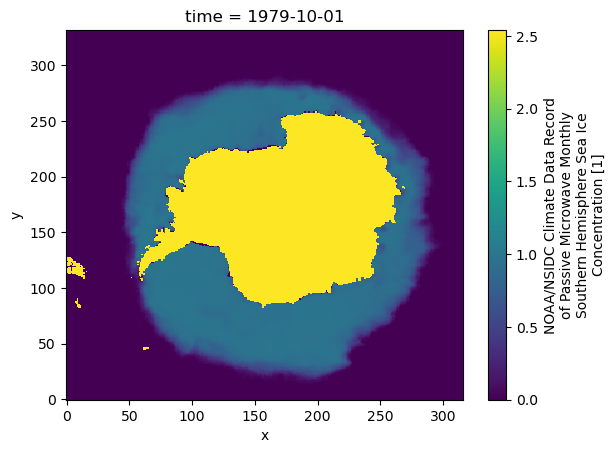

In [11]:
# make test plot of SIC
sic_v4[11].plot()

The NSIDC provides SIC on an equal-area, 25km x 25km polar stereographic grid. To make the plotting easier, we convert the xgrid and ygrid values to lat/lons then remap the data onto a 0.5deg x 0.5deg lat/lon grid.

In [12]:
# convert polar stereo x-y coordinates to lat-lons
# see: https://github.com/nsidc/polarstereo-lonlat-convert-py

true_scale_lat = 70  # true-scale latitude in degrees 
re = 6378.137  # earth radius in km
ecc = 0.01671 # earth eccentricity

XX_sic, YY_sic = np.meshgrid(sic_v4.xgrid.values, sic_v4.ygrid.values)

XX_sic_km, YY_sic_km = XX_sic/1e3, YY_sic/1e3
lons_sic_grid, lats_sic_grid = polar_xy_to_lonlat(XX_sic_km, YY_sic_km,true_scale_lat, 
                                                  re, ecc, hemisphere='south')

In [13]:
# examine lat/lon coordinates for SIC

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# plt.sca(axes[0])
# im = axes[0].contourf(lons_sic_grid)
# plt.title("SIC longitude distribution (degs)")
# plt.colorbar(im, ax=axes[0])

# plt.sca(axes[1])
# im = axes[1].contourf(lats_sic_grid)
# plt.colorbar(im, ax=axes[1])
# plt.title("SIC latitude distribution (degs)")

In [14]:
## map sic data to uniform latlon grid
grid_res = 0.5

# combine x and y dimensions to facilitate bin averaging
sic_v4_arr = sic_v4.values
sic_v4_arr_2d = sic_v4_arr.reshape(sic_v4_arr.shape[0], -1)

# limit remapping to weddell sea sector
print("may take a few seconds...")
lons_sic_v2 = np.arange(sst_ds.lon.values.min(), 
                        sst_ds.lon.values.max()+grid_res, grid_res)
lats_sic_v2 = np.arange(sst_ds.lat.values.min(), 
                        sst_ds.lat.values.max()+grid_res, grid_res)

# uncomment for full circumpolar remapping (takes longer)
# print("may take a few minutes...")
# lons_sic_v2 = np.arange(0, 360+grid_res, grid_res)
# lats_sic_v2 = np.arange(-80, -40+grid_res, grid_res)

lons_sic_v2_grid, lats_sic_v2_grid = np.meshgrid(lons_sic_v2, lats_sic_v2)
sic_ylen, sic_xlen = lons_sic_v2_grid.shape

sic_tlen = len(sic_v4.time)
sic_remapped = np.ma.masked_all((sic_tlen, sic_ylen, sic_xlen))

# set degrees over which to bin average native SIC data 
# note: this is a bit crude, but should be ok for this purpose. 
dlat = grid_res*2 
dlon = grid_res*2

# mask sic values outside valid sic range
sic_v4_arr_2d = np.ma.masked_where(np.logical_or(sic_v4_arr_2d<0, sic_v4_arr_2d>1), sic_v4_arr_2d)

# convert sic to masked array  
#sic_v4_arr_2d = np.ma.masked_invalid(sic_v4_arr_2d)

for jj, lat in enumerate(lats_sic_v2):
    
    #print('Lat: %s' %lat)
    
    # subselect for latitude
    lat_jj = np.logical_and(lats_sic_grid>=lat-dlat/2, lats_sic_grid<lat+dlat/2)
    
    for ii, lon in enumerate(lons_sic_v2):
        
        # subselect for longitude
        lon_jj = np.logical_and(lons_sic_grid>=lon-dlon/2, lons_sic_grid<lon+dlon/2)
        
        # combine lat/lon subselection
        lat_lon_jj = np.logical_and(lat_jj, lon_jj)
        
        lat_lon_jj_1d = lat_lon_jj.flatten()
        
        if lat_lon_jj_1d.sum()==0:
            continue
        
        # bin average
        sic_remapped[:, jj, ii] = sic_v4_arr_2d[:, lat_lon_jj_1d].mean(axis=1)
        

may take a few seconds...


In [15]:
# plot remapped SIC
# plt.contourf(lons_sic_v2, lats_sic_v2, sic_remapped[11], vmin=0, vmax=1)
# plt.colorbar()

In [16]:
# # create a new data array
coords_dict = dict(lon=(["lon"], lons_sic_v2), lat=(["lat"], lats_sic_v2), time=sic_dtimes)
sic_remapped_da = xr.DataArray(sic_remapped, coords=coords_dict, dims=["time", "lat", "lon"])

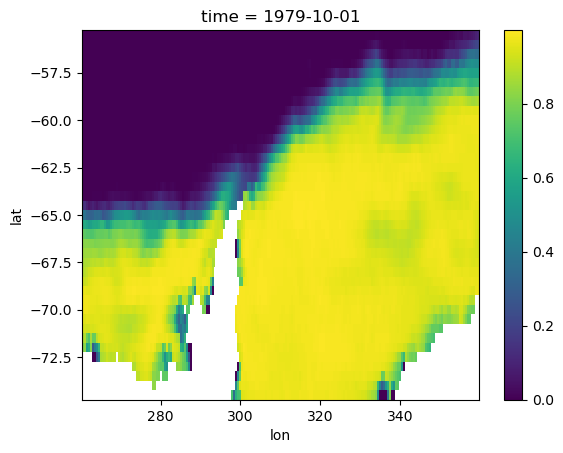

In [17]:
sic_remapped_da.isel(lat=lats_sic_v2<-55)[11].plot()

## Compute monthly climatologies and anomalies

In [18]:
# get monthly anomalies (SST)
clim_ref = [datetime(1982,1,1), datetime(2020,12,1)]
sst_dtimes = pd.to_datetime(sst_ds['time'].values)
sst_clim = sst_ds['sst'].isel(time=np.logical_and(sst_dtimes>=clim_ref[0], 
                                           sst_dtimes<=clim_ref[-1])).groupby('time.month').mean('time')

sst_anom = sst_ds['sst'].groupby('time.month') - sst_clim

In [19]:
#sic_merged = sic_merged.swap_dims({'tdim': 'time'}) # for 
sic_clim = sic_remapped_da.isel(time=np.logical_and(sic_dtimes>=clim_ref[0], 
                                        sic_dtimes<=clim_ref[-1])).groupby('time.month').mean('time')

sic_anom = sic_remapped_da.groupby('time.month') - sic_clim 

In [20]:
chl = chl_ds['chlor_a']
chl_clim = chl.isel(time=np.logical_and(chl_dtimes>=clim_ref[0], 
                                        chl_dtimes<=clim_ref[-1])).groupby('time.month').mean('time')

chl_anom = chl.groupby('time.month') - chl_clim

In [21]:
# from paper: #60o 24.44'S, 46o 04.45'W to 60o 18.29'S, 45o 53.51'W
ship_coords = [[hf.convert_dms_dec(-60, -24.33, 0), hf.convert_dms_dec(-46, -4.45)]]
ship_coords.append([hf.convert_dms_dec(-60, -18.29, 0), hf.convert_dms_dec(-45, -53.51)])
ship_coords = np.array(ship_coords)
ship_coords

array([[-60.4055    , -46.07416667],
       [-60.30483333, -45.89183333]])

## Generate figure plot

In [22]:
# consolidate data 
data_dict = {}

data_dict['sst'] = sst_ds['sst']
data_dict['sst_anom'] = sst_anom
data_dict['sst_clim'] = sst_clim
data_dict['sst_anom_dtimes'] = sst_dtimes
data_dict['sst_dtimes'] = sst_dtimes
data_dict['sst_anom_clvls']  = np.arange(-1.6, 1.6001, 0.1)
data_dict['sst_anom_cmap'] = 'coolwarm'
data_dict['sst_anom_label'] = "SST anomaly ($^{\circ}$C)"
data_dict['sst_label'] = "SST ($^{\circ}$C)"

data_dict['chl'] = chl
data_dict['chl_clim'] = chl_clim
data_dict['chl_dtimes'] = chl_dtimes
data_dict['chl_clvls']  = np.arange(0.2, 1.601, 0.05)
data_dict['chl_cmap'] = 'viridis'
data_dict['chl_label'] = "Chlorophyll-a (mg/m$^3$)"

data_dict['sic'] = 100*sic_remapped_da
data_dict['sic_clim'] = 100*sic_clim
data_dict['sic_dtimes'] = sic_dtimes
data_dict['sic_label'] = "SIC (%)"

#data_dict['float_dtimes'] = float_dtimes
data_dict['soccom_ds'] = soccom_ds
#data_dict['argo_ds_list'] = argo_ds_list
data_dict['ship_coords'] = ship_coords

In [23]:
float_lats = soccom_ds.LATITUDE
float_lons = soccom_ds.LONGITUDE
float_dtimes = pd.to_datetime(soccom_ds['JULD'].values)

mean_ship_loc = ship_coords.mean(axis=0)

# compute distance between float and ship
dist = []

for ii in range(len(float_lats)):
    dd = sw.dist([mean_ship_loc[0], float_lats[ii]], [mean_ship_loc[1], float_lons[ii]])[0][0]
    dist.append(dd)
    time_str = float_dtimes[ii].strftime("%B %d, %Y")
    #print("Time: %s, lat: %.2f, lon: %.2f, distance: %.2f" %(time_str, float_lats[ii], float_lons[ii], dd))
    
dist = np.array(dist)
print("Mean ship location: %.2f lat, %.2f lon" %(mean_ship_loc[0], mean_ship_loc[1]))
print("Min distance between float and ship %.2f km" %dist.min())

Mean ship location: -60.36 lat, -45.98 lon
Min distance between float and ship 190.73 km


<xarray.DataArray 'sst' (time: 12)>
array([ 1.5687499 ,  2.2196875 ,  1.3356249 ,  0.83375   ,  0.42624998,
       -0.06687501, -0.865625  , -1.101875  , -1.1612499 , -0.751875  ,
       -0.3959375 ,  0.12562498], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 1982-12-01


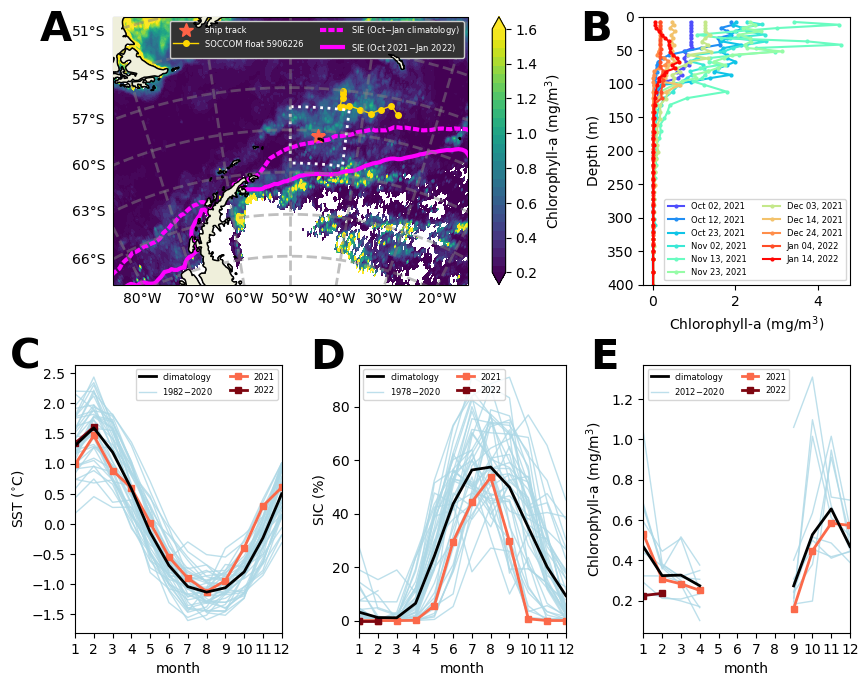

In [29]:
fz = 10
time_range = np.array([datetime(2021, 10, 1), datetime(2022, 1, 15)])
map_vble='chl' # use 'sst_anom' for testing. 'chl' takes a while to plot

fig_fmt = '.jpg' # alternatively '.png', '.jpg' (dpi=300)
dpi = 600

line_col_update = {'sic_clim':'magenta', 'sic_mon':'magenta', 
                   'region_box': 'w', 'soccom_float': 'gold', 'argo_float': '0.8',
                   'ship': 'tomato'}

_ = hf.generate_panel_map(data_dict, save_plot=True, time_avg=True,
                    focus_box_size=[4, 8], map_vble=map_vble, line_col_update=line_col_update,
                    fz=fz, leg_fz=fz-4, leg_loc=1, fig_size=(10, 8),
                    tr=time_range, combo_fig=True, dpi=dpi, fig_fmt=fig_fmt, plot_dir=plot_dir)
